In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pathlib
import time
import random
import tree as miptree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from model.threshold_guess import compute_thresholds, cut
from model.gosdt import GOSDT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

# Data Preprocessing

### Default Data

In [2]:
default_data = pd.read_csv('/Users/andrew/Documents/MBS/Practicum/Data/Default/default_data.csv') 

In [3]:
# Setting column limit for easy viewing to bypass limit

pd.set_option('display.max_columns', 500)

In [4]:
#Convert Account Age and Credit History Length columns to months

default_data['AVG_ACCT_AGE_MOS']= (default_data['AVERAGE_ACCT_AGE'].str.split(pat='yrs',n=1).str[0].astype('int')*12)+(default_data['AVERAGE_ACCT_AGE'].str.split(pat='yrs',n=1).str[1].str.split(pat='mon').str[0].astype('int'))

default_data['CREDIT_HIST_MOS']= (default_data['CREDIT_HISTORY_LENGTH'].str.split(pat='yrs',n=1).str[0].astype('int')*12)+(default_data['CREDIT_HISTORY_LENGTH'].str.split(pat='yrs',n=1).str[1].str.split(pat='mon').str[0].astype('int'))

default_data.drop(columns=['CREDIT_HISTORY_LENGTH', 'AVERAGE_ACCT_AGE'], inplace=True)

In [5]:
#Calculate (DOB - Disbursal Date) and convert to Days

born = pd.to_datetime(default_data['DATE_OF_BIRTH'],format = '%d-%m-%Y')
disbursed = pd.to_datetime(default_data['DISBURSAL_DATE'],format = '%d-%m-%Y')

default_data['AGE_IN_DAY_AT_DISBURSE'] = (disbursed - born).dt.days

default_data.drop(columns=['DATE_OF_BIRTH','DISBURSAL_DATE'], inplace=True)


In [6]:
#Drop unique identifiers

default_data.drop(columns=['PERFORM_CNS_SCORE_DESCRIPTION','SUPPLIER_ID','BRANCH_ID','UNIQUEID','CURRENT_PINCODE_ID','EMPLOYEE_CODE_ID'], inplace=True)
# default_data.drop(columns=['PERFORM_CNS_SCORE_DESCRIPTION','UNIQUEID','CURRENT_PINCODE_ID','EMPLOYEE_CODE_ID'], inplace=True)

In [7]:
# Time for encoding

# First some features are numeric that should be treated as categorical...

default_data = default_data.astype({'MANUFACTURER_ID': 'object', 'STATE_ID' : 'object'})
# default_data = default_data.astype({'BRANCH_ID': 'object', 'SUPPLIER_ID': 'object','MANUFACTURER_ID': 'object', 'STATE_ID' : 'object'})

In [8]:
# Ready to run in the models!

default_model_data = pd.get_dummies(default_data, dtype='float32')

default_model_data.head()

,DISBURSED_AMOUNT,ASSET_COST,LTV,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,AVG_ACCT_AGE_MOS,CREDIT_HIST_MOS,AGE_IN_DAY_AT_DISBURSE,MANUFACTURER_ID_45,MANUFACTURER_ID_48,MANUFACTURER_ID_49,MANUFACTURER_ID_51,MANUFACTURER_ID_67,MANUFACTURER_ID_86,MANUFACTURER_ID_120,MANUFACTURER_ID_145,MANUFACTURER_ID_152,MANUFACTURER_ID_153,MANUFACTURER_ID_156,EMPLOYMENT_TYPE_Salaried,EMPLOYMENT_TYPE_Self employed,STATE_ID_1,STATE_ID_2,STATE_ID_3,STATE_ID_4,STATE_ID_5,STATE_ID_6,STATE_ID_7,STATE_ID_8,STATE_ID_9,STATE_ID_10,STATE_ID_11,STATE_ID_12,STATE_ID_13,STATE_ID_14,STATE_ID_15,STATE_ID_16,STATE_ID_17,STATE_ID_18,STATE_ID_19,STATE_ID_20,STATE_ID_21,STATE_ID_22
0,50578,58400,89.55,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12633,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47145,65550,73.23,1,1,0,0,0,0,598,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,23,23,12110,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53278,61360,89.63,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57513,66113,88.48,1,1,0,0,0,0,305,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,8,15,9066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52378,60300,88.39,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,14901,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
len(default_model_data.columns)

66

#### Set TTS

In [10]:
# y = default_model_data.LOAN_DEFAULT
# x = default_model_data.drop(columns=['LOAN_DEFAULT'])

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42)

# len(X_train)

In [11]:
y = default_model_data.LOAN_DEFAULT
x = default_model_data.drop(columns=['LOAN_DEFAULT'])


X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size=0.9, random_state=random.randrange(22))
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.9, random_state=random.randrange(78))
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(x, y, test_size=0.9, random_state=random.randrange(34))
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(x, y, test_size=0.9, random_state=random.randrange(88))
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(x, y, test_size=0.9, random_state=random.randrange(42))


### SMOTE???

In [12]:
# len(default_model_data[default_model_data['LOAN_DEFAULT'] == 1])/len(default_model_data)

In [26]:
sm = SMOTE(random_state=27)
X_train_1, y_train_1 = sm.fit_resample(X_train_1, y_train_1)
X_train_2, y_train_2 = sm.fit_resample(X_train_2, y_train_2)
X_train_3, y_train_3 = sm.fit_resample(X_train_3, y_train_3)
X_train_4, y_train_4 = sm.fit_resample(X_train_4, y_train_4)
X_train_5, y_train_5 = sm.fit_resample(X_train_5, y_train_5)

print(len(y_train_1[y_train_1 == 1])/len(y_train_1), len(y_train_1))

0.5 36328


In [27]:
# Change names here to test different samples
# Use these for all models so they are consistent (aside from OCT as it doesn't run on such large datasets)

X_train, X_test, y_train, y_test = X_train_1, X_test_1, y_train_1, y_test_1

## GOSDT

In [15]:
# GBDT parameters for threshold and lower bound guesses
n_est = 5
max_depth = 5

# guess thresholds
X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
X_test_guessed = cut(X_test.copy(), thresholds)
X_test_guessed = X_test_guessed[header]
print("train set column names == test set column names: {}".format(list(X_train_guessed.columns)==list(X_test_guessed.columns)))

# guess lower bound
start_time = time.perf_counter()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_guessed, y_train.values.flatten())
warm_labels = clf.predict(X_train_guessed)
elapsed_time = time.perf_counter() - start_time
lb_time = elapsed_time

# save the labels from lower bound guesses as a tmp file and return the path to it.
labelsdir = pathlib.Path('./labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels",index=None)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: Th

train set column names == test set column names: True


In [16]:
# train GOSDT model

config = {
            "regularization": 0.001,
            "depth_budget": 5,
            "warm_LB": True,
            "reference_LB": True,
            "path_to_labels": labelpath,
            "time_limit": -1,
            "similar_support": False,
            "feature_transform": False,
            "allow_small_reg": True
            
        }

model = GOSDT(config)

model.fit(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
print("evaluate the model, extracting tree and scores", flush=True)

# get the results
train_acc = model.score(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
n_leaves = model.leaves()
n_nodes = model.nodes()
time = model.utime

print("Model training time: {}".format(time))
print("Training accuracy: {}".format(train_acc))
print("# of leaves: {}".format(n_leaves))
print(model.tree)

gosdt reported successful execution
training completed. 0.000/0.000/101.619 (user, system, wall), mem=0 MB
bounds: [0.238137..0.238137] (0.000000) loss=0.226137, iterations=197830
evaluate the model, extracting tree and scores
Model training time: 0.0
Training accuracy: 0.7738634503083556
# of leaves: 12
if AADHAR_FLAG<=0.5 = 1 and EMPLOYMENT_TYPE_Salaried<=1.994779631786514e-05 = 1 and MANUFACTURER_ID_86<=0.9986819326877594 = 1 and VOTERID_FLAG<=0.5 = 1 then:
    predicted class: 1
    misclassification penalty: 0.004
    complexity penalty: 0.001

else if AADHAR_FLAG<=0.5 = 1 and EMPLOYMENT_TYPE_Salaried<=1.994779631786514e-05 = 1 and MANUFACTURER_ID_86<=0.9986819326877594 = 1 and VOTERID_FLAG<=0.5 != 1 then:
    predicted class: 0
    misclassification penalty: 0.017
    complexity penalty: 0.001

else if AADHAR_FLAG<=0.5 != 1 and EMPLOYMENT_TYPE_Salaried<=1.994779631786514e-05 = 1 and MANUFACTURER_ID_86<=0.9986819326877594 = 1 and MANUFACTURER_ID_86<=9.605120794731192e-06 = 1 then:

In [18]:
y_test_pred = model.predict(X_test_guessed)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.7784158330910841
Recall: 0.008527148775729411
Precision: 0.23490338164251207
F1: 0.016456901110523534


In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## OCT

In [ ]:
# Reshaping for OCT
# This requires very small dataset, only adjust size for this (i.e. train_test_split of .999, for example)

X_train_OCT = X_train.to_numpy()
y_train_OCT = y_train.to_numpy()

X_test_OCT = X_test.to_numpy()
y_test_OCT = y_test.to_numpy()

In [ ]:
octree = miptree.optimalDecisionTreeClassifier(max_depth=5, min_samples_split=10, alpha=0.01, warmstart=True, timelimit=300, output=True)
octree.fit(X_train_OCT, y_train_OCT)

In [ ]:
# Training accuracy
y_train_pred = octree.predict(X_train_OCT)
accuracy_score(y_train_OCT, y_train_pred)

In [ ]:
# Test accuracy
y_test_pred = octree.predict(X_test_OCT)
accuracy_score(y_test_OCT, y_test_pred)


print("Accuracy:", accuracy_score(y_test_OCT, y_test_pred))
print("Recall:", recall_score(y_test_OCT, y_test_pred))
print("Precision:", precision_score(y_test_OCT, y_test_pred))
print("F1:", f1_score(y_test_OCT, y_test_pred))

In [ ]:
confusion_matrix(y_test_pred, y_test_OCT)

In [ ]:
# Ignore

# boctree = miptree.binOptimalDecisionTreeClassifier(max_depth=3, min_samples_split=2, warmstart=True, timelimit=600, output=True)
# boctree.fit(X_train_OCT, y_train_OCT)

# # Training accuracy
# y_train_pred = boctree.predict(X_train_OCT)
# accuracy_score(y_train_OCT, y_train_pred)

# mfoctree = miptree.maxFlowOptimalDecisionTreeClassifier(max_depth=5, alpha=0.005, warmstart=True, timelimit=300, output=True)
# mfoctree.fit(X_train_OCT, y_train_OCT)

## Logistic (Lasso)

In [28]:
clf = LogisticRegression(random_state=0, max_iter=10000, penalty="l1", solver="saga").fit(X_train, y_train)

In [29]:
# y_train_pred = clf.predict(X_train)
# print(accuracy_score(y_train, y_train_pred))

# Test accuracy
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.4289383765648902


In [30]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.4289383765648902
Recall: 0.7868675758908931
Precision: 0.24515293359741763
F1: 0.3738353895272582


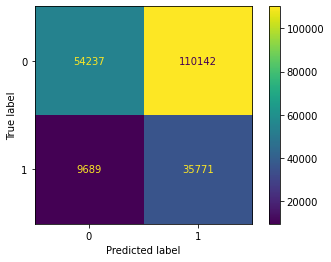

In [31]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state =7)
clf.fit(X_train, y_train)

In [ ]:
y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

## CART

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

In [ ]:
y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))